### Условие

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* default - индикатор невозврата денежных средств

Сначала загрузим данные и визуализируем их

In [1]:
import pandas as pd

df = pd.read_csv('credit_card_default_analysis.csv', index_col='ID')

In [2]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

### Задание 1. 
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [4]:
gr1 = df[df["default"] == 0]
gr2 = df[df["default"] == 1]

In [5]:
gr1.shape, gr2.shape

((23364, 24), (6636, 24))

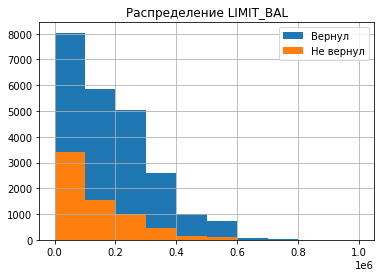

In [6]:
from matplotlib import pyplot as plt

    
def custom_hist(df1, df2, column, **kwargs):
    # функция для удобной визуализации результатов в виде гистограммы
    fig, ax = plt.subplots()
    df1.hist(column, ax=ax, label='Вернул', **kwargs)
    df2.hist(column, ax=ax, label='Не вернул', **kwargs)
    ax.legend()
    ax.set_title('Распределение ' + column)
    plt.show()
    
custom_hist(gr1, gr2, 'LIMIT_BAL', bins=10, range=(0,1000000))

Визуально распределения похожи. \
Проверим равенство интервальных оценок медиан с помощью бутстрепа

In [7]:
import numpy as np

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
np.random.seed(0)

gr1_median_scores = list(map(np.median, get_bootstrap_samples(gr1['LIMIT_BAL'].values, 1000)))
gr2_median_scores = list(map(np.median, get_bootstrap_samples(gr2['LIMIT_BAL'].values, 1000)))

print("95% confidence interval for the group 1 median credit limit:",  stat_intervals(gr1_median_scores, 0.05))
print("95% confidence interval for the group 2 median credit limit:",  stat_intervals(gr2_median_scores, 0.05))

95% confidence interval for the group 1 median credit limit: [150000. 150000.]
95% confidence interval for the group 2 median credit limit: [80000. 90000.]


Бутстреп показал, что интервальные оценки медиан не пересекаются, значит медианы не равны.

Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни

In [9]:
from scipy import stats

stats.mannwhitneyu(gr1['LIMIT_BAL'].values, gr2['LIMIT_BAL'].values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Достигаемый уровень значимости очень мал, значит нулевую гипотезу о равенстве средних можно уверенно отвергнуть в пользу альтернативын на уровне значимости 0.05, т.е. средние значения "LIMIT_BAL" разные.

*Значимы ли полученные результаты с практической точки зрения?*

Результаты показывают, что в группе, в которой вернули кредит, медианное значение кредитного лимита выше почти в два раза. Это логично, т.к. у пользователей с хорошей кредитной историей ниже риски невозврата, поэтому повышается кредитный лимит.

### Задание 2. 
Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

default  SEX
0        2      14349
         1       9015
1        2       3763
         1       2873
dtype: int64

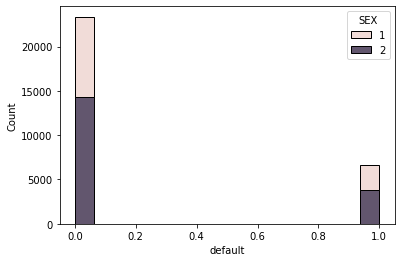

In [10]:
import seaborn as sns

sns.histplot(data=df[["default", "SEX"]], x="default", hue="SEX", multiple="stack")

df[["default", "SEX"]].value_counts()

На этом графике по оси Ох значению 0 соответствует группа вернувших кредит, 1 - не вернувших. Соотношения м/ж выглядят похожими.

Обновим значения в поле SEX, чтобы они принимали значения 0 для мужчин и 1 для женщин

In [11]:
gr1.loc[:, 'SEX'] = gr1.loc[:, 'SEX'] - 1
gr2.loc[:, 'SEX'] = gr2.loc[:, 'SEX'] - 1

gr1['SEX'].unique(), gr2['SEX'].unique()

/home/andrey/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


(array([1, 0]), array([1, 0]))

Проверим равенство средних долей с помощью доверительного интервала

In [12]:
from statsmodels.stats.proportion import proportion_confint

In [14]:
conf_gr1 = proportion_confint(sum(gr1['SEX']), 
                              gr1['SEX'].shape[0],
                              method = 'wilson')
conf_gr2 = proportion_confint(sum(gr2['SEX']), 
                              gr2['SEX'].shape[0],
                              method = 'wilson')

print ('interval for group 1 [%f, %f]' % conf_gr1)
print ('interval for group 2 [%f, %f]' % conf_gr2)

interval for group 1 [0.607890, 0.620373]
interval for group 2 [0.555102, 0.578938]


Как видим, интервалы не пересекаются, значит доли мужчин и женщин в выборках вернувших и не вернувших кредит отличаются. В группе 1 (вернули кредит) доля женщин выше, чем в группе 2 не вернувших кредит.

Сделаем проверку с помощью статистического критерия

In [ ]:
import scipy.stats

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [ ]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(gr1['SEX'], gr2['SEX']))
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(gr1['SEX'], gr2['SEX'])))

Видим, что достигаемый уровень значимости очень мал, значит, мы можем отвергнуть нулевую гипотезу о равенстве долей на уровне значимости 0.05. В первой группе (вернули кредит) доля женщин выше, доверительный интервал разности долей [0.033635, 0.060548].

### Задание 3. 
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

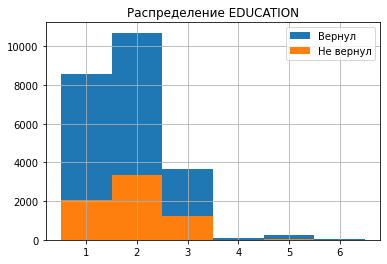

In [15]:
custom_hist(gr1, gr2, 'EDUCATION', bins=6, range=(0.5,6.5))

In [25]:
# выведем таблицу сопряжённости 
confusion_matrix = pd.crosstab(df['default'], df['EDUCATION'], normalize=False)
display(confusion_matrix)

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [32]:
# посчитаем ожидаемые значения из таблицы сопряжённости
from scipy.stats.contingency import expected_freq

df_expected = pd.DataFrame(expected_freq(confusion_matrix))
df_expected

,0,1,2,3,4,5,6
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


Разница между ожидаемым и полученным значением возврата долга

In [34]:
df_diff = df_expected - confusion_matrix
df_diff

,0,1,2,3,4,5,6
0,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812
1,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812


Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?

В виде относительной величины

In [43]:
df_diff/df_expected

,0,1,2,3,4,5,6
0,-0.284027,-0.037047,0.020735,0.039004,-0.210952,-0.201482,-0.082611
1,1.000000,0.130436,-0.073004,-0.137324,0.742719,0.709377,0.290856


Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

Наибольшее отличие в большую сторону от ожидаемого значения у уровня образования 3. Это наилучший индикатор возврата долга.

Наибольшее отличие в меньшую сторону от ожидаемого значения у уровня образования 0. Это наилучший индикатор невозврата долга.

### Задание 4.
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

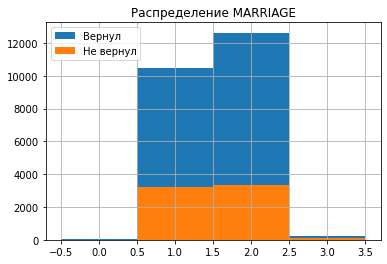

In [51]:
custom_hist(gr1, gr2, 'MARRIAGE', bins=4, range=(-0.5,3.5))

Можно посчитать коэффициент V Крамера, т.к. оба признака категориальные.

In [75]:
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [76]:
cross = pd.crosstab(df["default"], df['MARRIAGE'])
cross

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [77]:
cramers_corrected_stat(cross)

0.03299665874336609

Коэффициент V Крамера принимает значения от 0 до 1. Полученное значение близко к 0, значит связь между переменными не наблюдается.

### Задание 5.
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   
    a)  о равенстве медианных значений возрастов людей   
    b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

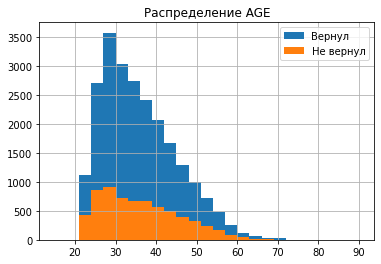

In [84]:
custom_hist(gr1, gr2, 'AGE', bins=25, range=(15,90))

Проверим равенство медиан с помощью бутстрепа.

In [86]:
np.random.seed(0)

gr1_median_scores = list(map(np.median, get_bootstrap_samples(gr1['AGE'].values, 5000)))
gr2_median_scores = list(map(np.median, get_bootstrap_samples(gr2['AGE'].values, 5000)))

print("95% confidence interval for the group 1 median age:",  stat_intervals(gr1_median_scores, 0.05))
print("95% confidence interval for the group 2 median age:",  stat_intervals(gr2_median_scores, 0.05))

95% confidence interval for the group 1 median age: [34. 34.]
95% confidence interval for the group 2 median age: [34. 35.]


Бутстреп показал, что интервальные оценки медиан пересекаются, значит медианы равны.

Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни

In [87]:
from scipy import stats

stats.mannwhitneyu(gr1['AGE'].values, gr2['AGE'].values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

P-value больше 0.05, значит нулевую гипотезу о равенстве средних нельзя отвергнуть в пользу альтернативы на уровне значимости 0.05.

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [91]:
from statsmodels.stats.weightstats import zconfint

print('95%% conf. interval for the mean age in gr1: [%f, %f]' % zconfint(gr1['AGE']))
print('95%% conf. interval for the mean age in gr2: [%f, %f]' % zconfint(gr2['AGE']))

95% conf. interval for the mean age in gr1: [35.300871, 35.533661]
95% conf. interval for the mean age in gr2: [35.492515, 35.958962]


Проверим перестановочным критерием

In [97]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

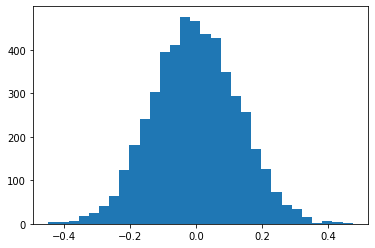

In [102]:
from matplotlib import pylab
pylab.hist(permutation_zero_dist_ind(gr1['AGE'], gr2['AGE'], max_combinations = 5000), bins=30)
pylab.show()

In [98]:
print("p-value: %f" % permutation_test(gr1['AGE'], gr2['AGE'], max_permutations=10000))

p-value: 0.017000


p-value меньше 0.05, значит нулевая гипотеза о равенстве средних возрастов может быть отвергнута на уровне значимости 0.05